# MNIST 텐서플로우

https://blog.ai.ovgu.de/posts/jens/2019/002_tf20_basic_mnist/index.html

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/swkim01/DSAC4/blob/main/gg-58-MNIST_텐서플로우.ipynb"><img src="https://github.com/swkim01/DSAC4/raw/main/colab_logo_32px.png" />구글 코랩에서 실행</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/swkim01/DSAC4/blob/main/gg-58-MNIST_텐서플로우.ipynb"><img src="https://github.com/swkim01/DSAC4/raw/main/GitHub-Mark-32px.png" />깃헙에서 소스 보기</a>
  </td>
</table>

# MNIST Dataset

Duplicate key in file PosixPath('/usr/local/lib/python3.8/dist-packages/matplotlib/mpl-data/matplotlibrc'), line 250 ('font.family:  UnDotum')
Duplicate key in file PosixPath('/usr/local/lib/python3.8/dist-packages/matplotlib/mpl-data/matplotlibrc'), line 251 ('font.family:  NanumGothic')
Duplicate key in file PosixPath('/usr/local/lib/python3.8/dist-packages/matplotlib/mpl-data/matplotlibrc'), line 403 ('axes.unicode_minus: True  # use Unicode for the minus symbol rather than hyphen.  See')


60000
10000


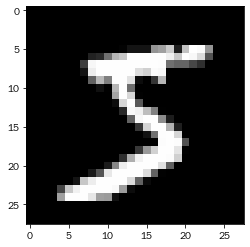

In [1]:
# 단층 퍼셉트론으로 구축하기
# 성능이 80% 정도 나온다
#import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

#from tensorflow.examples.tutorials.mnist import input_data
from keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

#원핫 인코딩을 선택한다
#mnist_data = input_data.read_data_sets('MNIST_data', one_hot=True)
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
x_train, x_test = np.array(train_images, np.float32), np.array(test_images, np.float32)
x_train, x_test = x_train.reshape([-1, 784]), x_test.reshape([-1, 784])
x_train, x_test = x_train / 255., x_test / 255.
y_train, y_test = to_categorical(train_labels, num_classes=10), to_categorical(test_labels, num_classes=10)

print(len(train_images))
print(len(test_images))

plt.imshow(train_images[0], cmap="Greys_r")



### Tensorflow 1.0

In [ ]:
#!curl https://github.com/swkim01/DSAC4/blob/main/datasets.py -o datasets.py
from datasets import MNISTDataset

In [ ]:
import tensorflow.compat.v1 as tf
tf.compat.v1.disable_eager_execution()

input_size = 784
no_classes = 10
batch_size = 100
total_batches = 200

mnist_data = MNISTDataset(x_train, y_train, x_test, y_test,
                    batch_size=100)

# None은 임의의 크기를 담을 수 있다는 것을 말한다
x_input = tf.placeholder(tf.float32, shape=[None, input_size])
y_input = tf.placeholder(tf.float32, shape=[None, no_classes])

W = tf.Variable(tf.random_normal([input_size, no_classes]))
b = tf.Variable(tf.random_normal([no_classes]))

def model(X):
    return  tf.matmul(X, W) + b

logits = model(x_input)

# 크로스엔트로피와 소프트맥스를 사용한다
# 손실함수와, 최적화기를 선택
# 학습속도 0.5
softmax_cross_entropy = tf.nn.softmax_cross_entropy_with_logits(
    labels=y_input, logits=logits)
loss_operation = tf.reduce_mean(softmax_cross_entropy)
optimiser = tf.train.GradientDescentOptimizer(
    learning_rate=0.5).minimize(loss_operation)

# 초기화
session = tf.Session()
session.run(tf.global_variables_initializer())

# 배치 작업 수행 
# feed_dict 인자에 훈련 데이터 딕셔너이를 공급
for batch_no in range(total_batches):
    mnist_batch  = mnist_data.next_batch()
    t_images, t_labels = mnist_batch[0], mnist_batch[1]
    _, loss_value = session.run([optimiser, loss_operation], feed_dict={
        x_input: t_images,
        y_input: t_labels
    })

predictions = tf.argmax(logits, 1)
correct_predictions = tf.equal(predictions, tf.argmax(y_input, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_predictions,
                                            tf.float32))
#test_images, test_labels = mnist_data.test.images, mnist_data.test.labels
accuracy_value = session.run(accuracy_operation, feed_dict={
    x_input: mnist_data.test_data,
    y_input: mnist_data.test_labels
})
print('Accuracy : ', accuracy_value)
session.close()


### Tensorflow 2.0

In [9]:
import tensorflow as tf
#tf.executing_eagerly()

input_size = 784
no_classes = 10
batch_size = 100
total_batches = 200

train_steps = 1000
learning_rate = 0.1

# 데이터셋을 섞고 배치로 변환
train_data=tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data=train_data.repeat().shuffle(5000).batch(batch_size)

W = tf.Variable(tf.random.normal([input_size, no_classes])) # (784, 10)
b = tf.Variable(tf.random.normal([no_classes])) # (10,)

def model(X):
    return  tf.matmul(X, W) + b

def loss_func(y_pred, y_true):
    return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
            logits=y_pred, labels=y_true))

def accuracy(y_pred, y_true):
    preds = tf.equal(tf.argmax(y_pred, axis=1), tf.argmax(y_true, axis=1, output_type=tf.int64))
    return tf.reduce_mean(tf.cast(preds, tf.float32))

#logits = model(x_input)

# 반복 학습
# dataset.take(c): batch_size 만큼씩  c 번 뽑는다.
for step, (x_batch, y_batch) in enumerate(train_data.take(train_steps), 1):
    with tf.GradientTape() as tape:
        #logits = tf.matmul(img_batch, W) + b
        logits = model(x_batch)
        xent = loss_func(logits, y_batch)
        
    grads = tape.gradient(xent, [W, b])
    W.assign_sub(learning_rate * grads[0])
    b.assign_sub(learning_rate * grads[1])
    
    if not step % 100:
        #preds = tf.argmax(logits, axis=1, output_type=tf.int32)
        #acc = tf.reduce_mean(tf.cast(tf.equal(preds, tf.argmax(y_batch, axis=1,output_type=tf.int32)),
        #                            tf.float32))
        acc = accuracy(logits, y_batch)
        print("Loss: {} Accuracy: {}".format(xent, acc))

test_acc = accuracy(model(x_test), y_test)
print("Test Accuracy: {}".format(test_acc))

Loss: 4.065742015838623 Accuracy: 0.4300000071525574
Loss: 2.7999489307403564 Accuracy: 0.5400000214576721
Loss: 1.8316439390182495 Accuracy: 0.6800000071525574
Loss: 1.5354799032211304 Accuracy: 0.7200000286102295
Loss: 1.2007083892822266 Accuracy: 0.7799999713897705
Loss: 1.3124220371246338 Accuracy: 0.7699999809265137
Loss: 1.4081932306289673 Accuracy: 0.75
Loss: 0.6000255346298218 Accuracy: 0.8199999928474426
Loss: 0.9749221801757812 Accuracy: 0.7799999713897705
Loss: 0.9940370321273804 Accuracy: 0.7699999809265137
Test Accuracy: 0.8072999715805054


In [5]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
#X = mnist_data.train_data
X = train_images.reshape([-1, 784])
#y = mnist_data.train_labels
y = train_labels
rfc = RandomForestClassifier(n_estimators=50)
rfc.fit(X,y)   
#prediction = rfc.predict(test_images.reshape([-1, 784]))
#rfc.score(mnist_data.test_data, mnist_data.test_labels)
rfc.score(test_images.reshape([-1,784]), test_labels)

0.9651